In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
data = pd.read_csv("conversion_data.csv")

In [11]:
y = data.converted

# Pre-processing

In [12]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


## Tableau montre présence d'outliers sur colonne age et total_pages_visited

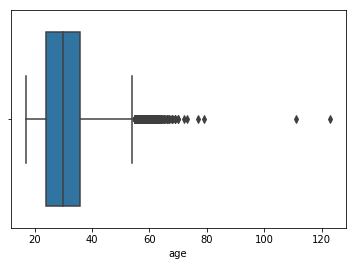

In [13]:
sns.boxplot(x='age',data = data)

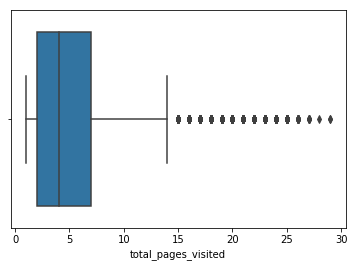

In [14]:
sns.boxplot(x='total_pages_visited',data = data)

In [15]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [16]:
age2 = remove_outlier(data,'age')
total_pages_visited2 = remove_outlier(data,'total_pages_visited')

In [17]:
len(age2)-len(data.age)

-2070

In [18]:
len(total_pages_visited2)-len(data.total_pages_visited)

-5663

### Outliers négligeables : représentent moins de 2% du dataset

## Visualisation des variables explicatives

## Nombre de pages

#### Corrélation significative entre achat et le nombre de pages visités :
#### - coorélation de 0.52 entre achat et nombre de pages visité
#### - graphique ci dessous montre que plus l'utilisateur voit de pages plus la conversion augmente
#### - indépendamment du pays, un utilisateur qui achète a vu au moins 5 pages, et 75% de ceux-ci en a vu au moins 12

In [19]:
data.corr()

,age,new_user,total_pages_visited,converted
age,1.000000,0.012343,-0.045922,-0.088797
new_user,0.012343,1.000000,-0.082541,-0.152374
total_pages_visited,-0.045922,-0.082541,1.000000,0.528994
converted,-0.088797,-0.152374,0.528994,1.000000


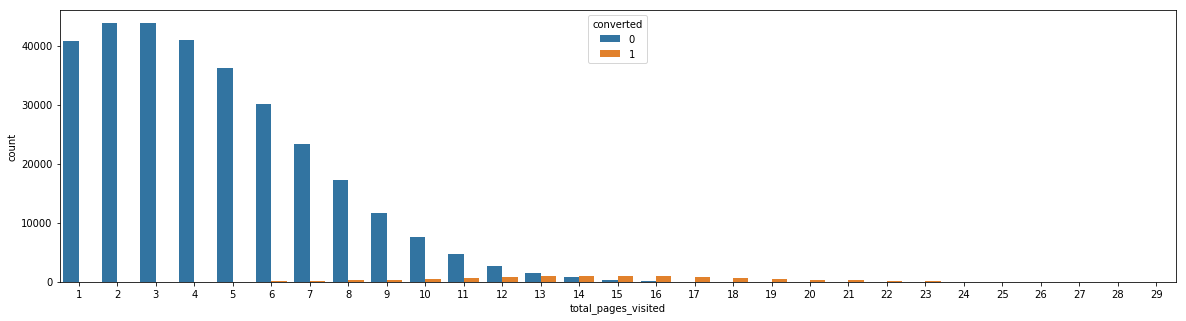

In [20]:
plt.figure(1, figsize=(20,5))
sns.countplot(x="total_pages_visited",data=data, hue="converted")

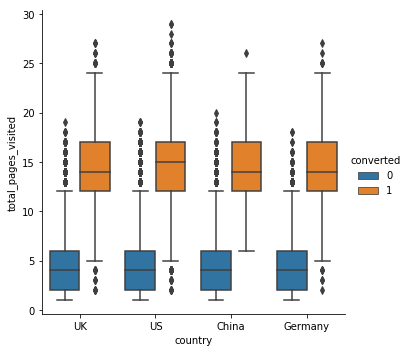

In [21]:
sns.catplot(x="country", y="total_pages_visited", data=data, kind = "box", hue ="converted")

### Origine du client

#### Proportion forte des US
#### Taux de conversion proportionnelement plus important avec les clients du UK
#### Taux de conversion des clients chinois trés faible

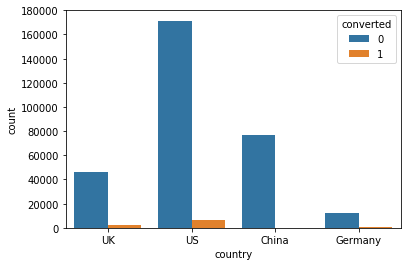

In [22]:
sns.countplot(x="country",data=data, hue="converted")

In [23]:
data.groupby("country").mean()

,age,new_user,total_pages_visited,converted
country,,,,
China,30.672972,0.698520,4.553523,0.001332
Germany,30.449985,0.677237,5.190717,0.062500
UK,30.451538,0.679835,5.082167,0.052632
US,30.566482,0.681985,4.930160,0.037801


### Age des clients

#### Majorité de personnes entre 20 et 40 ans

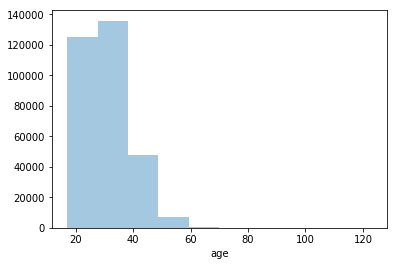

In [24]:
sns.distplot(data["age"],bins = 10,kde = False)

#### Taux de conversion plus important chez les jeunes
#### 75% des acheteurs ont moins de 30 ans indépendamment du pays

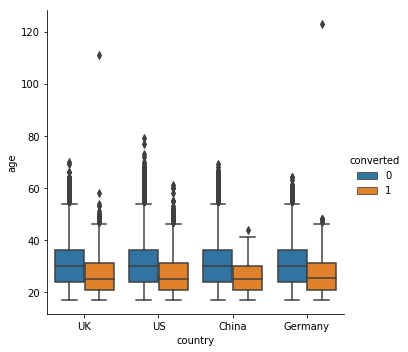

In [25]:
sns.catplot(x="country", y="age", data=data, kind = "box", hue ="converted")

### Nouvel utilisateur et origine web du client

#### Taux de conversion plus important pour les clients récurrents
#### Volatilité importante pour les nouveaux clients

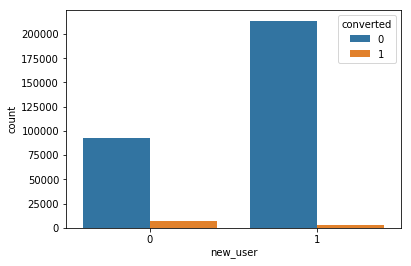

In [26]:
sns.countplot(x="new_user",data=data, hue="converted")

#### Taux de conversion proportionnelement plus important avec les clients venants de publicités cibléés (3,4%)
#### La majeure partie des clients provienne des moteurs de recherche

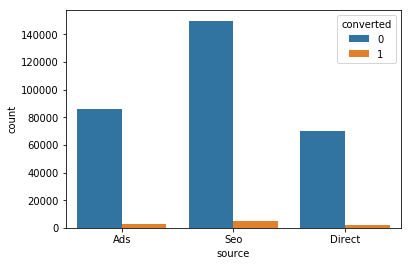

In [27]:
sns.countplot(x="source",data=data, hue="converted")

In [28]:
data.groupby("source").mean()

,age,new_user,total_pages_visited,converted
source,,,,
Ads,30.534742,0.685700,4.899538,0.034483
Direct,30.567978,0.686854,4.816901,0.028169
Seo,30.590835,0.684681,4.883946,0.032895


### Machine Learning
#### Split training and test

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [30]:
data = pd.get_dummies(data)

In [31]:
X = data.loc[:, data.columns != 'converted']
y = data['converted']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)
logreg = LogisticRegression()

In [33]:
logreg.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Performance du modèle

In [34]:
y_pred = logreg.predict(X_test)
print('Accuracy : {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy : 0.99


In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
cm = confusion_matrix(y_test, y_pred)

In [37]:
cm

array([[91449,   351],
       [  960,  2100]])

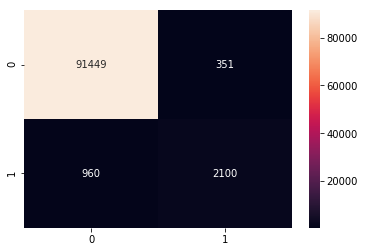

In [38]:
sns.heatmap(cm, annot=True, fmt='d')

### Déterminer hierarchie des variables explicatives

In [39]:
from sklearn.feature_selection import SelectKBest, chi2

In [40]:
X_new = SelectKBest(chi2, k='all').fit(X, y)

In [41]:
X_new.scores_

array([5.58042574e+03, 2.30914908e+03, 2.02697509e+05, 2.34695073e+03,
       3.82500000e+02, 6.44210526e+02, 1.75257732e+02, 1.40689655e+01,
       3.87887324e+01, 2.01315789e+00])

In [42]:
X.head()

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,1,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,0,1


In [45]:
X_new

SelectKBest(k='all', score_func=<function chi2 at 0x1a2568a598>)

#### Le nombre de pages visité est bien la variable la plus pertinente pour expliquer une conversion/un achat
#### L'age et le pays d'origine sont également importants mais dans une moindre mesure
#### La source de la clientèle n'apparait pas comme une variable fortement explicative


In [48]:
df = pd.DataFrame({"features":X.columns,"score":X_new.scores_})

In [49]:
df

,features,score
0,age,5580.425744
1,new_user,2309.149077
2,total_pages_visited,202697.509485
3,country_China,2346.950732
4,country_Germany,382.500000
5,country_UK,644.210526
6,country_US,175.257732
7,source_Ads,14.068966
8,source_Direct,38.788732
9,source_Seo,2.013158
